# Sentiment Analysis on IMDB Reviews: Classical ML vs Transformers

This notebook presents a comparative study of sentiment classification on the
IMDB movie reviews dataset using four approaches:

1. TF-IDF + Logistic Regression (classical baseline)
2. Zero-shot classification with DeBERTa
3. Fine-tuned BERT
4. Prompt-based inference with T5 (FLAN-T5)

The objective is to analyze the trade-offs between classical NLP pipelines,
zero-shot transfer, supervised fine-tuning, and instruction-following models
in terms of performance, data efficiency, and practical usability.


In [2]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from transformers.pipelines.pt_utils import KeyDataset
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback, pipeline, AutoTokenizer, AutoModelForSequenceClassification, AutoModelForSeq2SeqLM
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset
from tqdm.auto import tqdm
import nltk
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings("ignore")

import os
os.environ["WANDB_DISABLED"] = "true" # Otherwise we dont see the progress bar in BERT training

import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
import random

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [ ]:
# Download stopwords if not already downloaded
nltk.download('stopwords')

# Get English stop words
stop_words = set(stopwords.words('english'))

In [6]:
def make_pretty(styler):
    styler.set_properties(**{'border': "1px solid", 'text-align': 'left'})
    styler.format(precision=3)

    return styler

## Data Loading and Overview

We use the IMDB dataset of 50k movie reviews, labeled as positive or negative.
Duplicates are removed to avoid data leakage.


In [7]:
df = pd.read_csv("/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv")
df = df.drop_duplicates()
df.sample(5, random_state=123).head().style.pipe(make_pretty)

## Exploratory Analysis: Review Lengths

We analyze the distribution of review lengths to understand input size
characteristics and inform tokenization limits for transformer models.


In [9]:
label_counts = df['sentiment'].value_counts()
positive = label_counts['positive']
negative = label_counts['negative']
print(f"We have {positive} positive reviews and {negative} negative reviews.")

We have 24884 positive reviews and 24698 negative reviews.


In [10]:
def count_words(text):
    """Return the number of words in a review."""
    return len(text.split())

df["word_count"] = df["review"].apply(count_words)

print("Overall Word Count Summary:")
print(df["word_count"].describe())

print("\nSummary by Label:")
label_summary = df.groupby("sentiment")["word_count"].describe()
print(label_summary)


Overall Word Count Summary:
count    49582.000000
mean       231.350167
std        171.542020
min          4.000000
25%        126.000000
50%        173.000000
75%        281.000000
max       2470.000000
Name: word_count, dtype: float64

Summary by Label:
             count        mean         std   min    25%    50%    75%     max
sentiment                                                                    
negative   24698.0  229.596607  165.103430   4.0  128.0  174.0  278.0  1522.0
positive   24884.0  233.090620  177.688169  10.0  125.0  172.0  284.0  2470.0


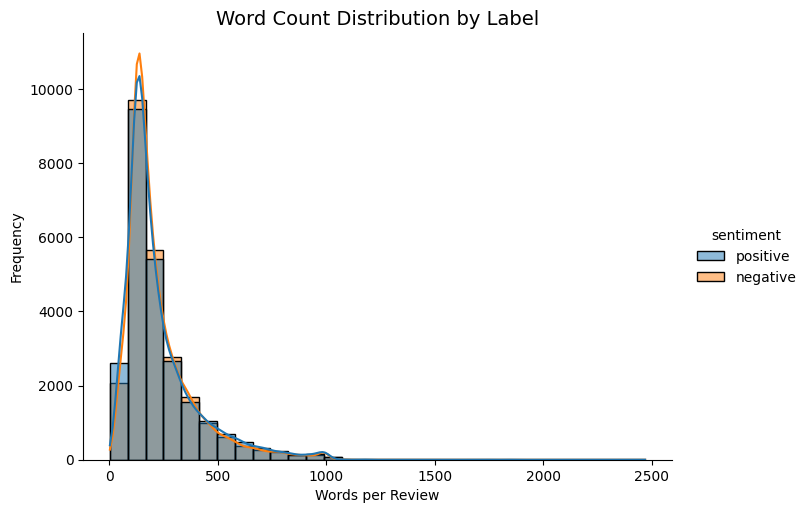

In [11]:
sns.displot(
    data=df,
    x="word_count",
    hue="sentiment",
    bins=30,
    kde=True,
    height=5,
    aspect=1.4
)

plt.title("Word Count Distribution by Label", fontsize=14)
plt.xlabel("Words per Review")
plt.ylabel("Frequency")
plt.show()



## Text Cleaning

We remove HTML tags, URLs, and normalize whitespace. Text is lowercased for
compatibility with uncased transformer models.

In [12]:
def clean_text(text):
    # Lowercase (for uncased models)
    text = text.lower()

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove URLs
    text = re.sub(r'(https?://\S+|www\.\S+)', '', text)

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['cleaned_review'] = df['review'].apply(clean_text)

## TF-IDF + Logistic Regression (Classical Baseline)

We start with a classical NLP baseline using TF-IDF features and a
logistic regression classifier. This provides a reference point to quantify
the benefit of transformer-based models.


In [13]:
encoder = LabelEncoder()
df['sentiment_enc'] = encoder.fit_transform(df['sentiment'])

X_train, X_test, y_train, y_test = train_test_split(
    df['cleaned_review'], df['sentiment_enc'], test_size=0.3, 
    random_state=123, stratify=df['sentiment_enc']
)

Logistic Regression Accuracy: 0.89
              precision    recall  f1-score   support

    negative       0.90      0.88      0.89      7410
    positive       0.88      0.90      0.89      7465

    accuracy                           0.89     14875
   macro avg       0.89      0.89      0.89     14875
weighted avg       0.89      0.89      0.89     14875



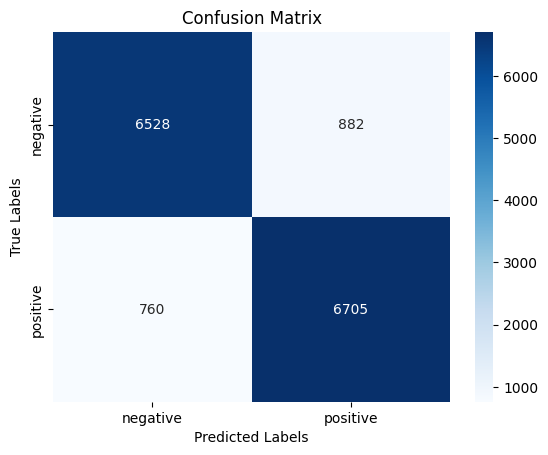

In [14]:
vectorizer = TfidfVectorizer(max_features=5000)

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

log_reg = LogisticRegression()

log_reg.fit(X_train, y_train)

log_reg_preds = log_reg.predict(X_test)

log_reg_acc = accuracy_score(y_test, log_reg_preds)
print(f"Logistic Regression Accuracy: {log_reg_acc:.2f}")

class_names = encoder.classes_
print(classification_report(y_test, log_reg_preds, target_names=class_names))

cm = confusion_matrix(y_test, log_reg_preds)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## Zero-Shot Sentiment Classification with DeBERTa

We evaluate a pretrained DeBERTa model in a zero-shot setting, without any
task-specific fine-tuning, using natural language label prompts.
To control runtime, we subsample an equal number of positive and negative reviews.


In [15]:
bert_df = df[['cleaned_review', 'sentiment']].rename(columns={'sentiment': 'label', 'cleaned_review': 'text'})
bert_df = bert_df.groupby('label', group_keys=False).apply(lambda x: x.sample(3000, random_state=42))

encoder = LabelEncoder()
bert_df['label'] = encoder.fit_transform(bert_df['label'])

In [ ]:
%%capture
dataset = Dataset.from_pandas(bert_df)

model_id = 'MoritzLaurer/mDeBERTa-v3-base-mnli-xnli'
tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(model_id).to(device)

classifier = pipeline(
    "zero-shot-classification",
    model=model,
    tokenizer=tokenizer,
    device=device,
    truncation=True
)

batch_size = 32
results = tqdm(classifier(KeyDataset(dataset, 'text'), 
               candidate_labels=encoder.classes_, 
               batch_size=batch_size),
               total=len(dataset))

predicted_labels = [res['labels'][0] for res in results]
predicted_scores = [res['scores'][0] for res in results]

dataset = dataset.add_column("predicted_labels", encoder.transform(predicted_labels))
dataset = dataset.add_column("predicted_scores", predicted_scores)

In [18]:
print(classification_report(dataset['label'], dataset["predicted_labels"], target_names=encoder.classes_))

              precision    recall  f1-score   support

    negative       0.77      0.89      0.82      3000
    positive       0.87      0.73      0.79      3000

    accuracy                           0.81      6000
   macro avg       0.82      0.81      0.81      6000
weighted avg       0.82      0.81      0.81      6000



## BERT

## Fine-Tuned BERT for Sentiment Classification

We fine-tune a pretrained BERT model on a labeled subset of the IMDB dataset.
This represents a fully supervised transformer approach.


In [19]:
bert_df = df[['cleaned_review', 'sentiment']].rename(columns={'sentiment': 'label', 'cleaned_review': 'text'})
bert_df = bert_df.groupby('label', group_keys=False).apply(lambda x: x.sample(3000, random_state=42))

encoder = LabelEncoder()
bert_df['label'] = encoder.fit_transform(bert_df['label'])

id2label = {i: class_ for i, class_ in enumerate(encoder.classes_)}
label2id = {value: key for key, value in id2label.items()}

X_train, X_temp, y_train, y_temp = train_test_split(
    bert_df['text'].tolist(), bert_df['label'].tolist(), 
    test_size=0.3, random_state=123, stratify=bert_df['label']
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, 
    random_state=123, stratify=y_temp
)


train_dataset = Dataset.from_dict({'text': X_train, 'label': y_train})
val_dataset = Dataset.from_dict({'text': X_val, 'label': y_val})
test_dataset = Dataset.from_dict({'text': X_test, 'label': y_test})

In [ ]:
%%capture
model_id = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(
    model_id, num_labels=2, id2label=id2label, label2id=label2id
).to(device)

def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        padding="max_length",
        truncation=True,
        max_length=512
    )

train_tokenized = train_dataset.map(tokenize_function, batched=True)
val_tokenized = val_dataset.map(tokenize_function, batched=True)
test_tokenized = test_dataset.map(tokenize_function, batched=True)

# HF expects the target column to be named "labels"
train_tokenized = train_tokenized.rename_column("label", "labels")
val_tokenized = val_tokenized.rename_column("label", "labels")
test_tokenized = test_tokenized.rename_column("label", "labels")

# set tensor format
train_tokenized.set_format("torch")
val_tokenized.set_format("torch")
test_tokenized.set_format("torch")

In [ ]:
# Define training arguments for fine-tuning the BERT model
training_args = TrainingArguments(
    output_dir="./model",                  # Directory to store model checkpoints and outputs
    eval_strategy="epoch",                 # Evaluate the model at the end of each epoch
    learning_rate=2e-5,                    # Learning rate for AdamW optimizer
    per_device_train_batch_size=8,         # Batch size per device
    num_train_epochs=5,                   # Total number of training epochs
    weight_decay=0.01,                     # Weight decay for regularization
    logging_dir="./logs",                  # Directory to save training logs
    logging_steps=10,                      # Log metrics every 10 steps
    save_strategy="epoch",                 # Save model checkpoint at the end of each epoch
    load_best_model_at_end=True,           # Load the best model based on eval metric after training
    metric_for_best_model="f1_macro",      # Metric to determine the best model
    greater_is_better=True,                # Higher F1 score is better
    save_total_limit=2,                    # Keep only the last 2 checkpoints
    run_name="sentiment_classification",    # Name for experiment tracking/logging
    disable_tqdm=False
)


# Define metric computation function for validation
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro"),
        "f1_weighted": f1_score(labels, preds, average="weighted"),
    }

# Initialize the Trainer — handles training, evaluation, and checkpointing
trainer = Trainer(
    model=model,                           # The model to be fine-tuned
    args=training_args,                    # Training configuration defined above
    train_dataset=train_tokenized,         # Tokenized training dataset
    eval_dataset=val_tokenized,            # Tokenized validation dataset
    compute_metrics=compute_metrics,       # Evaluation metrics function
)

In [22]:
%%capture
trainer.train()

In [23]:
logits, labels, _ = trainer.predict(test_tokenized)
preds = np.argmax(logits, axis=-1)

print("\nClassification report (test):")
print(classification_report(labels, preds, target_names=encoder.classes_, digits=3))


Classification report (test):
              precision    recall  f1-score   support

    negative      0.934     0.911     0.922       450
    positive      0.913     0.936     0.924       450

    accuracy                          0.923       900
   macro avg      0.924     0.923     0.923       900
weighted avg      0.924     0.923     0.923       900



## Prompt-Based Sentiment Classification with T5

We explore instruction-based sentiment classification using FLAN-T5.
Instead of fine-tuning, sentiment is inferred by prompting the model in
natural language with different prompt styles.


In [24]:
t5_df = df[['cleaned_review', 'sentiment']].rename(columns={'sentiment': 'label', 'cleaned_review': 'review'})
t5_df = t5_df.groupby('label', group_keys=False).apply(lambda x: x.sample(100, random_state=42))

encoder = LabelEncoder()
t5_df['label'] = encoder.fit_transform(t5_df['label'])

reviews = t5_df['review'].tolist()
true_labels = t5_df['label'].tolist()

In [25]:
%%capture
model_name = "google/flan-t5-base"  # "small" for smaller model
tokenizer = AutoTokenizer.from_pretrained(model_name, truncation=True, padding=True, max_length=512, use_fast=True)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

In [26]:
prompts = {
    "simple": "Answer whether the following review is 'Positive' or 'Negative': '{}'",
    "detailed": "Read the following review carefully. Answer whether it is 'Positive' or 'Negative'. Here is the review: '{}'",
    "expert": "You are an expert in sentiment analysis. Analyze the sentiment of the following review and answer whether it is 'Positive' or 'Negative': '{}'"
}

In [ ]:
results = {"simple": [], "detailed": [], "expert": []}

for review in reviews:
    for key, prompt in prompts.items():

        formatted_prompt = prompt.format(review)
        inputs = tokenizer(formatted_prompt, return_tensors="pt")
        outputs = model.generate(inputs["input_ids"], max_new_tokens=3)
        response = tokenizer.decode(outputs[0], skip_special_tokens=True)
        
        if response.lower() == 'positive':
            predicted_label = encoder.transform(['positive'])[0]
        elif response.lower() == 'negative':
            predicted_label = encoder.transform(['negative'])[0]
        else:
            predicted_label = -1

        results[key].append(predicted_label)

    

In [28]:
for key in results.keys():
    print(f"Classification report for {key} style:")
    print(classification_report(true_labels, results[key], target_names=encoder.classes_))
    print("-" * 50)
    

Classification report for simple style:
              precision    recall  f1-score   support

    negative       0.99      0.97      0.98       100
    positive       0.97      0.99      0.98       100

    accuracy                           0.98       200
   macro avg       0.98      0.98      0.98       200
weighted avg       0.98      0.98      0.98       200

--------------------------------------------------
Classification report for detailed style:
              precision    recall  f1-score   support

    negative       0.98      0.97      0.97       100
    positive       0.97      0.98      0.98       100

    accuracy                           0.97       200
   macro avg       0.98      0.97      0.97       200
weighted avg       0.98      0.97      0.97       200

--------------------------------------------------
Classification report for expert style:
              precision    recall  f1-score   support

    negative       0.99      0.97      0.98       100
    positive 

Across different prompt formulations, FLAN-T5 produces highly consistent
predictions. This indicates that for a simple binary sentiment task, once the
instruction is clearly specified, the model is largely invariant to superficial
prompt wording.

This robustness is desirable in practice, but also suggests that prompt
engineering has limited impact for straightforward classification problems,
in contrast to more open-ended generation or reasoning tasks.
